# Use Case for TP53 Downstream Effects

In order to show more of what we can do with our mutation data, let's look at the gene TP53. TP53 is a tumor suppressing gene that is very important in helping prevent mutation. Attached [here](https://en.wikipedia.org/wiki/P53) is a wikipedia article for a further introduction of TP53.

As we know, a mutation in a gene often causes significant funcional changes to the protein that it produces. We know that sometimes an alteration to that specific protein can cause immediate harmful effects to the cell. But in order to measure the mutation's complete effect, we also need to look at the proteins that interact with our mutated protein directly, as well as the ones that may be involved later on in a process that involves many proteins. This use case will show how to find some of those proteins, and how a mutation in our gene (TP53) affects them as well.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes, as well as our CPTAC data.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.utils as al

en = cptac.Endometrial()
co = cptac.Colon()
ccrcc = cptac.Ccrcc()

gene = "TP53"

omics = "proteomics"
#omics = "transcriptomics"
#omics = "phosphoproteomics"
#omics = "acetylproteomics"

# Step 2: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with TP53 directly. The method identified here, the bioplex method, is a process that includes tagging our protein of interest and then identifying the proteins around it that come into direct contact. When we call the get_interacting_proteins_bioplex method, this returns a list of proteins that interact with our gene in this way.

In [2]:
interacting_proteins = al.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
for interacting_protein in interacting_proteins:
    print(interacting_protein)

Interacting Proteins:
HNF4A
FBXW7
MDM4
CELA2B
FAM111A
MDM2
RORC
AURKA
FAM175B
GPR156
HOMER3
CUL7
CUL9


# Step 3: Run T-tests to Find Significant Comparisons

Now we create a new dataframe containing protein measurements for the interacting proteins that we are interested in. This is done with endometrial cancer, because we know that mutations in TP53 have been shown to be especially important in endometrial cancer, but can also be done across all of the other cancers in the dataset. Later on in this use case we will show an example with colon cancr.

In [3]:
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

Next, since in order to make comparisons we will want our "Label" column to contain one of two values- either "Mutated" or "Wildtype." We will then delete other columns

In [4]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

In [5]:
protdf.head()

Name,HNF4A_proteomics,FBXW7_proteomics,MDM4_proteomics,CELA2B_proteomics,FAM111A_proteomics,MDM2_proteomics,RORC_proteomics,AURKA_proteomics,FAM175B_proteomics,GPR156_proteomics,HOMER3_proteomics,CUL7_proteomics,CUL9_proteomics,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status,Label
Sample_ID,,,,,,,,,,,,,,,,,,
S001,NaN,NaN,NaN,NaN,0.363000,NaN,NaN,NaN,NaN,NaN,-0.443,0.0408,0.0355,[Missense_Mutation],[p.R248W],Single_mutation,Tumor,Mutated
S002,NaN,NaN,NaN,NaN,0.601000,NaN,NaN,0.311,NaN,NaN,-0.897,-0.1430,0.1480,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S003,NaN,NaN,NaN,NaN,-0.280000,NaN,NaN,NaN,NaN,NaN,-0.451,0.0999,0.1130,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S005,NaN,NaN,NaN,NaN,0.066500,NaN,NaN,-0.798,NaN,NaN,-0.034,-0.7460,0.1680,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Wildtype
S006,NaN,NaN,NaN,NaN,-0.000411,NaN,NaN,3.110,NaN,NaN,-0.535,-0.1200,-0.2530,[Missense_Mutation],[p.S241C],Single_mutation,Tumor,Mutated


Since we are only interested in interacting protein levels, here we trim down the dataframe and drop unwanted columns.

In [6]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

We take the column names, which are the interacting proteins, and create a list in order to run our t-tests for each protein individually.

In [7]:
col_list = list(protdf.columns)
col_list.remove('Label')

In [8]:
print(col_list)

['HNF4A_proteomics', 'FBXW7_proteomics', 'MDM4_proteomics', 'CELA2B_proteomics', 'FAM111A_proteomics', 'MDM2_proteomics', 'RORC_proteomics', 'AURKA_proteomics', 'FAM175B_proteomics', 'GPR156_proteomics', 'HOMER3_proteomics', 'CUL7_proteomics', 'CUL9_proteomics']


Now we call wrap_ttest, which is an accessory function in cptac.utils. It expects one column with a binary variable (which is 'Label' for us as either mutated or wildtype), and all other data as qualitiative. It will then run ttests to determine if there is a statistically significant difference between the binary values and their respective qualitative data. For our case, it will tell us if there are significantly different measurements between wildtype and mutated samples.

In [9]:
print("Doing t-test comparisons\n")
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

1 significant comparisons!
         Comparison   P_Value
0  AURKA_proteomics  0.000016





Our t-test returned one protein whose levels were significantly changed by a mutation in TP53, aurora kinase. Attached [here](https://www.ncbi.nlm.nih.gov/pubmed/27933271) is an article that talks about the relationship between TP53 and aurora kinase. We will now create a boxplot to show exactly how levels of aurora kinase change with our gene's mutation.

# Step 4: Analyze Selected Protein

Now that we have selected the protein that we want to analyze, we will now show how to visualize the effects that a mutation in TP53 had on aurora kinase. First we want to create and trim down a dataframe in order to easily graph our results. To do this, we simply want the sample ID, the protein level, and a label as to whether the sample is mutated or wildtype.

In [10]:
protdf = en.join_omics_to_mutations(omics_df_name='proteomics',omics_genes='AURKA',mutations_genes='TP53')
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

protdf.head()

Name,AURKA_proteomics,Label
Sample_ID,,
S001,NaN,Mutated
S002,0.311,Wildtype
S003,NaN,Wildtype
S005,-0.798,Wildtype
S006,3.110,Mutated


Now we will plot our data using the seaborn library as a stripplot on top of a boxplot in order to see the distributions.

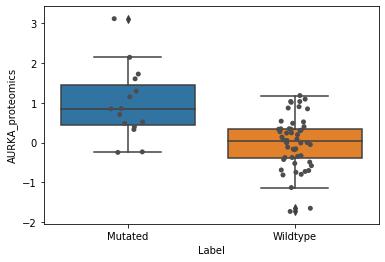

In [11]:
sns.boxplot(data = protdf, x = 'Label', y = 'AURKA_proteomics')
sns.stripplot(data = protdf, x = 'Label', y = 'AURKA_proteomics', jitter = True, dodge = True, color = '.3')

# Step 5: Example Using General Transcription Factor (ARID1A)

Now that we have analyzed proteins that interact with TP53, we will now look at a general transcription factor, ARID1A. Proteins made by this gene interact with a wide range of genes, as it alters chromatin structure around them. Attached [here](https://en.wikipedia.org/wiki/ARID1A) is a wikipedia article about ARID1A for further reading.

The following code box will go through thousands of proteins contained in our dataset and look at how a mutation in ARID1A affects them. Because of the high amount of comparisons, this will take a little bit of time. In the end, we will have a list of genes affected by ARID1A.

In [12]:
gene = "ARID1A"
print("\nGene: ", gene)

'''Use all proteins'''

'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics) #Here is the different line
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
    
'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")
    
'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons



/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8 significant comparisons!
          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10
1   MAP1S_proteomics  1.010149e-07
2    DPF2_proteomics  2.166609e-07
3   KDM4B_proteomics  4.414547e-07
4    RRM1_proteomics  4.455870e-07
5  MAP7D3_proteomics  4.880890e-07
6   CYTH3_proteomics  3.109396e-06
7   CEP78_proteomics  3.749172e-06





Each of the proteins shown can be individually analyzed in the same manner that we showed above. For further ideas about how to analyze larger lists of genes, refer to usecase 5.

# Step 6: Use the same tools on another cancer type

Now that we have looked at endometrial cancer, we will now use the same tools on colon cancer. We will find that there will not be any similar results. This goes to show how unique cancer types are, as around 20 percent of our colon cancer samples have mutations in ARID1A, but there are no similar effects like we see in endometrial cancer.

In [13]:
print("\nGene: ", gene)
    
'''Use all proteins'''
'''Create dataframe in order to do comparisons with wrap_ttest'''
protdf = co.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

'''Create the binary valued column needed to do the comparison'''
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Label'] = 'Mutated'
    else:
        protdf.at[ind,'Label'] = 'Wildtype'

'''Format the dataframe correctly'''
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

'''Make list of columns to be compared using t-tests'''
col_list = list(protdf.columns)
col_list.remove('Label')

print("Doing t-test comparisons\n")
    
'''Call wrap_ttest, pass in formatted dataframe'''
wrap_results = al.wrap_ttest(protdf, 'Label', col_list)

'''Print results, if anything significant was found'''
if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons

No significant comparisons.
